In [1]:
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import seaborn as sns

In [2]:
adata_exut = anndata.read_h5ad('../results/evaluations/exut_adata_evaluated_embeddings.h5ad')
adata_merfish = anndata.read_h5ad('../results/evaluations/merfish_adata_evaluated_embeddings.h5ad')
adata_smartseq = anndata.read_h5ad('../results/evaluations/smartseq_adata_evaluated_embeddings.h5ad')
datasets = [adata_exut,adata_merfish,adata_smartseq]

adata_mnist = anndata.read_h5ad('../results/evaluations/mnist_adata_evaluated_embeddings.h5ad')
adata_sim = anndata.read_h5ad('../results/evaluations/exut-sim-theta-10-real-seqdepths_adata_evaluated_embeddings.h5ad')

## Embeddings figure

In [3]:
pretty_titles = {'pca2':'2D PCA',
'elephant':'Picasso',
'tsne':'t-SNE',
'umap':'UMAP'}   

In [4]:
embedding_type2color ={'elephant':'tab:blue',
                        'pca2':'tab:orange',
                        'tsne':'tab:green',
                        'umap':'tab:red'}
pretty_datasets = {'exut':'Ex Utero',
                   'merfish':'MERFISH',
                   'smartseq':'Smart-seq',
                   'mnist':'MNIST'}

In [5]:
def plot_embedding(ad,ax,embedding_type,seed_to_use,show_title=True):
    
    x = ad.obsm[f'x_{embedding_type}_seed_{seed_to_use}']
    colors = ad.obs['colors']
    
    ax.scatter(*x.T,c=colors,s=3,lw=0,rasterized=True)
    ax.set_aspect('equal')
    ax.axis('off')
    if show_title:
        ax.set_title(pretty_titles[embedding_type])
    
    plt.tight_layout()

In [6]:
def add_dataset_names(ax,ad,dataset_text_offset=0):
    ax.text(0.5,-0.05+dataset_text_offset,pretty_datasets[ad.uns['dataset']],transform=ax.transAxes,ha='center')

In [7]:
def plot_top_hlines(ax,fig,embedding_type,add_text=True,yline=0.9,ytext=0.895):
    
    xmin = {'pca2': 0.25,
            'elephant': 0,
            'tsne':0.5,
            'umap':0.75}
    
    ax.hlines(yline,xmin[embedding_type]+0.01,xmin[embedding_type]+0.25-0.01,color=embedding_type2color[embedding_type],lw=3,transform=fig.transFigure,clip_on=False,zorder=0)
    
    if add_text:
        ax.text(xmin[embedding_type]+0.125,ytext,s=pretty_titles[embedding_type],transform=fig.transFigure,ha='center',backgroundcolor='white',zorder=0)

In [8]:
n_cols=4
pagewidth=6.5
height=pagewidth/n_cols
embedding_types = ['elephant','pca2','tsne','umap']
seed_to_use=0

/tmp/ipykernel_22230/2439669897.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[6.5    2.4375]


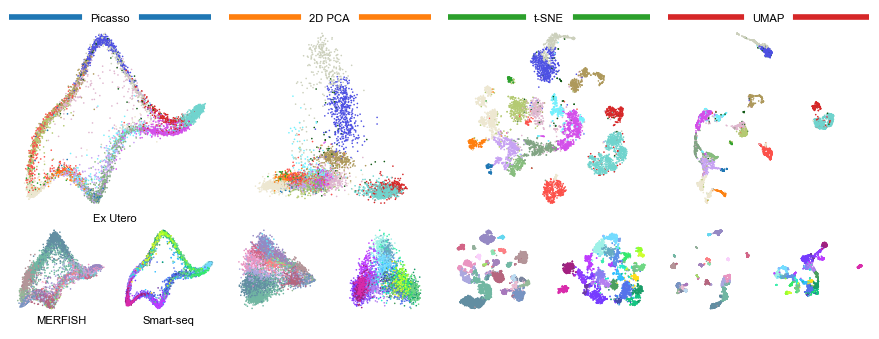

In [9]:
with plt.style.context('../mpl_style.txt'):

    fig = plt.figure(figsize=(pagewidth,height*1.5))
    axes_large = [plt.subplot2grid(shape=(3, 8), loc=(0, col),rowspan=2,colspan=2) for col in np.arange(8,step=2)]
    axes_small_left = [plt.subplot2grid(shape=(3, 8), loc=(2, col),rowspan=1,colspan=1) for col in np.arange(8,step=2)]
    axes_small_right = [plt.subplot2grid(shape=(3, 8), loc=(2, col),rowspan=1,colspan=1) for col in np.arange(start=1,stop=8,step=2)]

    for ax,embedding_type in zip(axes_large,embedding_types):
        plot_embedding(ad=adata_exut,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use)
        ax.set_title('')
        plot_top_hlines(ax=ax,fig=fig,embedding_type=embedding_type,yline=0.95,ytext=0.938)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_exut,ax=ax,dataset_text_offset=0)
        
    for ax,embedding_type in zip(axes_small_left,embedding_types):
        plot_embedding(ad=adata_merfish,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use,show_title=False)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_merfish,ax=ax,dataset_text_offset=-0.08)

    for ax,embedding_type in zip(axes_small_right,embedding_types):
        plot_embedding(ad=adata_smartseq,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use,show_title=False)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_smartseq,ax=ax,dataset_text_offset=-0.08)
            
    fig.savefig(f'../results/figures/embeddings_combined.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig.savefig(f'../results/figures/embeddings_combined.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)    
    print(fig.get_size_inches())
    plt.show()

## Metrics figure

In [10]:
#pool metric data frames for single cell datasets
metrics_df = pd.concat([ad.uns['metrics_df'] for ad in datasets])
ami_df =pd.concat([ad.uns['ami_df'] for ad in datasets])

In [11]:
#retrieve knn accuarcy and silhouette score for high dimensional space
knn_accuracies_hd = {ad.uns['dataset']:ad.uns['knn_accuracy_hd'] for ad in datasets}
silhouette_scores_hd = {ad.uns['dataset']:ad.uns['silhouette_hd'] for ad in datasets}

In [12]:
#get AMI for best HDBSCAN clustering run
def get_best_run(df,metric_name):
    '''input: df that only has one metric present'''
    df = df.copy()
    df.reset_index(inplace=True,drop=True)
    max_idx = df.groupby(by=['dataset','scaled','embedding_type','seed'],as_index=False)['metric_value'].idxmax()['metric_value']
    max_df = df.loc[max_idx,:]
    max_df['metric'] = f'max {metric_name}'
    
    return max_df

In [13]:
ami_max_df = get_best_run(ami_df,'AMI')

In [14]:
plot_df = pd.concat([metrics_df,ami_max_df])
plot_df["embedding_x_dataset"] = plot_df["embedding_type"]+ "_x_" + plot_df['dataset']

In [15]:
#separate metrics from embeddings computed with and without Chari & Pachter scaling step
plot_df_normal = plot_df.query('scaled==False')
plot_df_scaled = plot_df.query('scaled==True')

### Plot prelims

In [16]:
palette = {'elephant_x_exut':'tab:blue',
           'pca2_x_exut':'tab:orange',
           'tsne_x_exut':'tab:green',
           'umap_x_exut':'tab:red',
           'dummy1':'k', #empty category for column spacing between datasets
           'dummy2':'k', #empty category for column spacing between datasets
           'elephant_x_merfish':'tab:blue',
           'pca2_x_merfish':'tab:orange',
           'tsne_x_merfish':'tab:green',
           'umap_x_merfish':'tab:red',
           'dummy3':'k', #empty category for column spacing between datasets
           'dummy4':'k', #empty category for column spacing between datasets
           'elephant_x_smartseq':'tab:blue',
           'pca2_x_smartseq':'tab:orange',
           'tsne_x_smartseq':'tab:green',
           'umap_x_smartseq':'tab:red'}

In [17]:
col_order = [f'inter-centroid distance corr',
             f'intra-cluster distance corr',
             'kNN accuracy',
             'kNN recall',
             'silhouette_score',
             'max AMI']

pretty_metrics_dict = {f'inter-centroid distance corr':'Inter-class\ncorrelation',
                           f'intra-cluster distance corr':'Intra-class\ncorrelation',
                           'kNN accuracy':'kNN accuracy',
                           'kNN recall':"kNN recall",
                           'max AMI':'max. AMI across\nHDBSCAN parameters',
                           'silhouette_score':'Silhouette coefficient'}

def plot_evals(plot_df,knn_accuracies_hd_dict,silhouette_scores_hd_dict,
               file_suffix,suptitle,
               height=3,aspect=1.5,legend_loc=(0.6,0.3),scale=1):

    g = sns.FacetGrid(plot_df, col="metric",col_wrap=2,sharey=False,sharex=False,
                      height=height,aspect=aspect,
                      col_order=col_order)

    g.map_dataframe(sns.pointplot,
                    errorbar=("pi",100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)
    
    legend_data = g._legend_data
    new_legend_data = {'2D PCA':legend_data['pca2_x_exut'],
                       'Picasso':legend_data['elephant_x_exut'],
                       't-SNE':legend_data['tsne_x_exut'],
                       'UMAP':legend_data['umap_x_exut']}    
    g.add_legend(legend_data=new_legend_data,loc=legend_loc,frameon=True,ncols=2,columnspacing=0.1,handletextpad=0.1)
    
    for (metric), ax in g.axes_dict.items():

        plt.sca(ax)
        
        tick_positions=[1.5,7.5,13.5]
        plt.xticks(tick_positions,['Ex Utero','MERFISH','Smart-seq'])
        
        plt.tick_params(bottom = False) 
        plt.xlabel('')
        
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')  
        
        mindata_intra = np.min(plot_df.query(f'metric=="intra-cluster distance corr"')['metric_value'])
        
        ylim_lo = -0.05
        ax.set_yticks([0,0.5,1])

        
        if metric == f"inter-centroid distance corr":
            ylim_lo += mindata_intra            
            letter='a'            
            
        if metric == f"intra-cluster distance corr":
            ylim_lo += mindata_intra
            letter='b'
        
        if metric == "kNN accuracy":
            ax.hlines(knn_accuracies_hd_dict['exut'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['merfish'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['smartseq'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=knn_accuracies_hd_dict['exut']+0.03,s='\nHD space',c='tab:gray',fontsize=5)
            letter='c'
            
        if metric == 'kNN recall':
            letter='d'
        
        if metric == 'max AMI':
            letter='f'
            
        if metric == 'silhouette_score':
            letter='e'
            ylim_lo += -0.5
            ax.set_yticks([-0.5,0,0.5,1])
            
            ax.hlines(silhouette_scores_hd_dict['exut'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['merfish'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['smartseq'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=silhouette_scores_hd_dict['exut']+0.05,s='HD space',c='tab:gray',fontsize=5)
            
        ax.set_ylim(ylim_lo,top=1)
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo,tick_pos-2,tick_pos+2,colors='k',lw=0.5)
    
    
        if letter in ['c','d']:
            y_correction=0.0025
        else:
            y_correction=0
        if letter in ['f']:
            x_correction=0.02
        else:
            x_correction=0
            
        ax.text(-0.17+x_correction,0.9675+y_correction,letter,transform=ax.transAxes,fontweight='bold',fontsize=8)
        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)
        
    plt.tight_layout()
    sns.despine(trim=True,bottom=True)
    
    plt.suptitle(suptitle,y=1.03)
    g.figure.savefig(f'../results/figures/metrics{file_suffix}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    g.figure.savefig(f'../results/figures/metrics{file_suffix}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    return g

In [18]:
#select only L2-based metrics for remaining figures
l2_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr"'
plot_df_normal_l2 = plot_df_normal.query(l2_query)
plot_df_scaled_l2 = plot_df_scaled.query(l2_query)

### Main figure
(unscaled high-dimensional space used for embeddings and evaluation)

/home/jan/anaconda3/envs/elephant_analysis_env2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_22230/2395853273.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


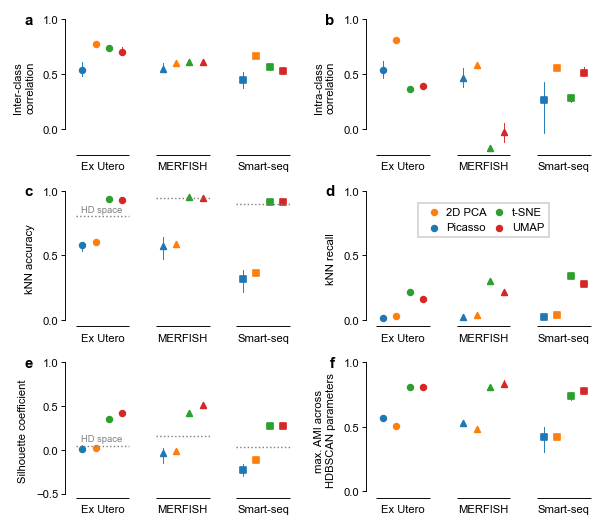

In [19]:
with plt.style.context('../mpl_style.txt'):
    g=plot_evals(plot_df_normal_l2,file_suffix="_unscaled_L2",suptitle="",
                 knn_accuracies_hd_dict=knn_accuracies_hd,silhouette_scores_hd_dict=silhouette_scores_hd,
                 height=1.3,aspect=1.377,legend_loc=(0.68,0.55),scale=0.9)

In [20]:
#minimum kNN accuracy across runs and datasets for UMAP or tSNE
min(plot_df.query('scaled==False & metric=="kNN accuracy"& (embedding_type=="tsne" | embedding_type=="umap")')['metric_value'])

0.9101298701298701

### Additional figure: L1 vs L2 distances in the Chari & Pachter distance correlation metrics: 

In [21]:
#make l1 vs l2 dataframe
l1l2_query = 'metric=="intra-cluster distance corr" | metric=="inter-centroid distance corr" | metric=="intra-cluster L1 distance corr" | metric=="inter-centroid L1 distance corr"'
plot_df_normal_l1l2 = plot_df_normal.query(l1l2_query)

In [22]:
def plot_l1_vs_l2(plot_df,height=3,aspect=1.5,legend_loc=(0.6,0.3),scale=1,l1_pachter=False):

    g = sns.FacetGrid(plot_df, col="metric",col_wrap=2,sharey=False,sharex=False,
                      height=height,aspect=aspect,
                      col_order=['inter-centroid L1 distance corr',
                                 'intra-cluster L1 distance corr',
                                 'inter-centroid distance corr',
                                 'intra-cluster distance corr'])

    pretty_metrics_dict = {'inter-centroid L1 distance corr':'L1 Inter-class\ncorrelation',
                       'inter-centroid distance corr':'L2 Inter-class\ncorrelation',
                       'intra-cluster L1 distance corr':'L1 Intra-class\ncorrelation',
                       'intra-cluster distance corr':'L2 Intra-class\ncorrelation'}
    
    g.map_dataframe(sns.pointplot,
                    errorbar=("pi",100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)
    
    legend_data = g._legend_data
    new_legend_data = {'2D PCA':legend_data['pca2_x_exut'],
                    'Picasso':legend_data['elephant_x_exut'],
                    't-SNE':legend_data['tsne_x_exut'],
                    'UMAP':legend_data['umap_x_exut']}    
    g.add_legend(legend_data=new_legend_data,loc=legend_loc,frameon=True,ncols=2,columnspacing=0.1,handletextpad=0.1)
    
    for (metric), ax in g.axes_dict.items():

        plt.sca(ax)
        
        tick_positions=[1.5,7.5,13.5]
        plt.xticks(tick_positions,['Ex Utero','MERFISH','Smart-seq'])
        
        plt.tick_params(bottom = False) 
        plt.xlabel('')
        
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')
        
        ylim_lo = min(plot_df['metric_value'])
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo,tick_pos-2,tick_pos+2,colors='k',lw=0.5)
        
        ax.set_yticks([0,0.5,1])
        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)
        
    plt.tight_layout()
    sns.despine(trim=True,bottom=True)
    
    g.figure.savefig('../results/figures/chari_pachter_metrics_l1_vs_l2.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    g.figure.savefig('../results/figures/chari_pachter_metrics_l1_vs_l2.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

    plt.show()
    return g

/home/jan/anaconda3/envs/elephant_analysis_env2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_22230/885626588.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


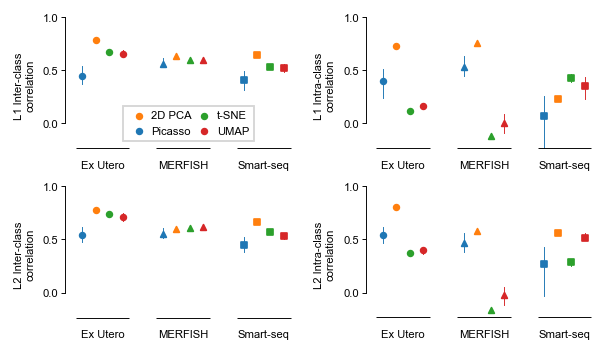

In [23]:
with plt.style.context('../mpl_style.txt'):
    plot_l1_vs_l2(plot_df_normal_l1l2,
                  legend_loc=(0.2,0.6),
                  height=1.3,aspect=1.377,scale=0.9)

### Additional figure: Chari & Pachter scaling step
(scaled high-dimensional space used as basis for embeddings, unscaled space used for evaluation)

/home/jan/anaconda3/envs/elephant_analysis_env2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_22230/2395853273.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


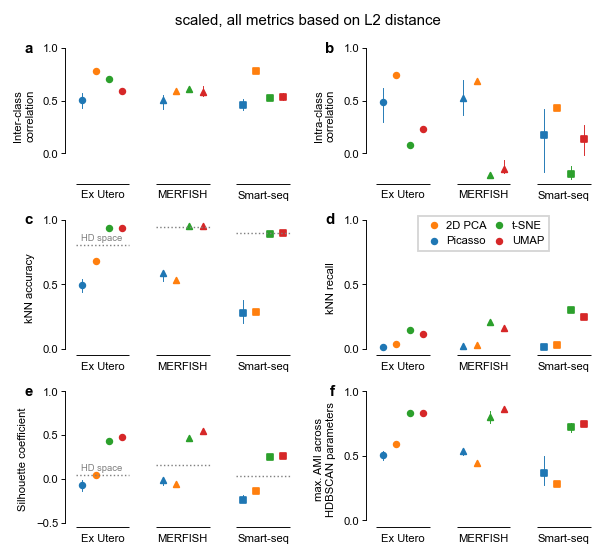

In [24]:
with plt.style.context('../mpl_style.txt'):
    g=plot_evals(plot_df_scaled_l2,file_suffix="_scaled_L2",suptitle="scaled, all metrics based on L2 distance",
                 knn_accuracies_hd_dict=knn_accuracies_hd,silhouette_scores_hd_dict=silhouette_scores_hd,
                 height=1.3,aspect=1.377,legend_loc=(0.68,0.55),scale=0.9)

## Additional datasets

In [25]:
def plot_evals_single_dataset(ad,plot_df,legend_loc_metrics = (0.05,0.3),legend_panel_metrics='kNN recall'):

    ## PREPARE
    nrows_grid = 5
    ncols_grid = 12
    fig = plt.figure(figsize=(6.5,6.5/4*1.5))
    axes_embeddings = [plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(0, col*3),          colspan=3,rowspan=3) for col in range(4)]
    axes_metrics =    [plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(3, col*2),          colspan=2,rowspan=2) for col in range(6)]

    ## EMBEDDINGS
    embedding_types = ['elephant','pca2','tsne','umap']
    for ax,embedding_type,xpos in zip(axes_embeddings,embedding_types,[0.13,0.37,0.63,0.87]):
        plot_top_hlines(ax=ax,fig=fig,embedding_type=embedding_type,yline=0.94,ytext=0.93)
        plot_embedding(ad=ad,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use)
        ax.set_title('')
        sns.despine(ax=ax,top=False)


    ## METRICS
    metrics = np.unique(plot_df['metric'])
    metrics_ordered = metrics[[0,1,2,3,5,4]]
    for metric, ax  in zip(metrics_ordered,axes_metrics):

        metric_idx = plot_df['metric']==metric
        data = plot_df.loc[metric_idx,:].copy()

        palette = {'Picasso':'tab:blue',
               '2D PCA':'tab:orange',
               't-SNE':'tab:green',
               'UMAP':'tab:red'}
        embedding_type_pretty_dict = {'pca2':'2D PCA',
                       'elephant':'Picasso',
                       'tsne':'t-SNE',
                       'umap':'UMAP'}

        embedding_types = data['embedding_type'].values
        data['embedding_type_pretty'] = [embedding_type_pretty_dict[et] for et in embedding_types]

        sns.pointplot(data=data,x='embedding_type_pretty',y='metric_value',hue='embedding_type_pretty',
                      ax=ax,
                      errorbar=("pi",100), errwidth=0.5,
                      palette=palette, order=list(palette.keys()))

        if metric == "kNN accuracy":
            ax.hlines(ad.uns['knn_accuracy_hd'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=ad.uns['knn_accuracy_hd']+0.03,s='\nHD space',c='tab:gray',fontsize=5)

        if metric == 'silhouette_score':
            ax.hlines(ad.uns['silhouette_hd'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=ad.uns['silhouette_hd']+0.05,s='HD space',c='tab:gray',fontsize=5)

        if metric == 'kNN recall':
            ax.legend(frameon=True,loc=legend_loc_metrics)  
        else:
            ax.get_legend().remove()

        if metric in ['inter-centroid distance corr', 'intra-cluster distance corr', 'silhouette_score']:
            ax.set_ylim(-1,1)
            ax.set_yticks([-1,0,1])
        else:
            ax.set_ylim(0,1)
            ax.set_yticks([0,0.5,1])
        
        
        ax.set_xticks([])
        ax.set_ylabel(pretty_metrics_dict[metric])
        ax.set_xlabel('')

        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)

    plt.tight_layout()
    fig.savefig(f'../results/figures/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig.savefig(f'../results/figures/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)    
    plt.show()

### Simulated Ex Utero

/tmp/ipykernel_22230/2439669897.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_22230/2607024326.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


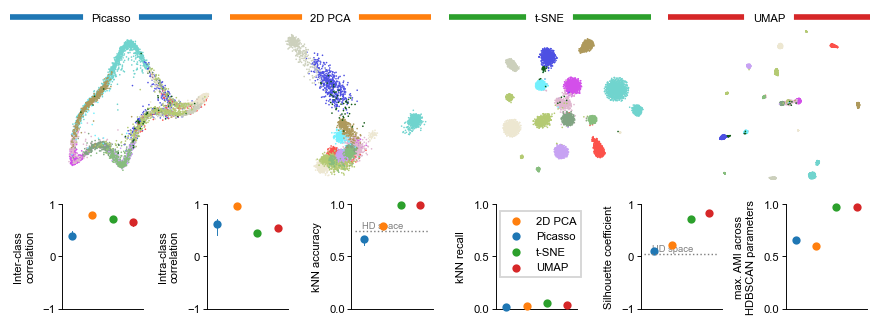

In [26]:
metrics_df_sim = adata_sim.uns['metrics_df']
ami_df_sim = adata_sim.uns['ami_df']

ami_max_df_sim = get_best_run(ami_df_sim,'AMI')
plot_df_sim = pd.concat([metrics_df_sim,ami_max_df_sim])
plot_df_sim = plot_df_sim.query('scaled==False')
l2_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr"'
plot_df_sim = plot_df_sim.query(l2_query)

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_sim,plot_df=plot_df_sim)

### MNIST

/tmp/ipykernel_22230/2439669897.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_22230/2607024326.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


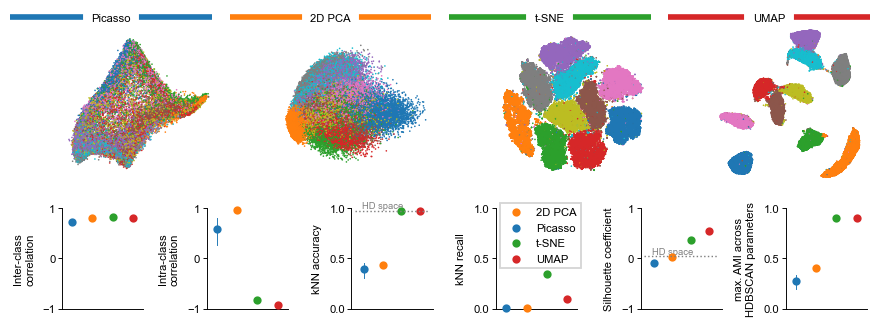

In [27]:
metrics_df_mnist = adata_mnist.uns['metrics_df']
ami_df_mnist = adata_mnist.uns['ami_df']

ami_max_df_mnist = get_best_run(ami_df_mnist,'AMI')
plot_df_mnist = pd.concat([metrics_df_mnist,ami_max_df_mnist])
plot_df_mnist = plot_df_mnist.query('scaled==False')
plot_df_mnist = plot_df_mnist.query(l2_query)

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_mnist,plot_df=plot_df_mnist,legend_loc_metrics=(0.05,0.4))

## Package versions

In [28]:
np.__version__

'1.24.3'

In [29]:
pd.__version__

'2.2.1'

In [30]:
anndata.__version__

'0.10.3'

In [31]:
import matplotlib; matplotlib.__version__

'3.7.2'

In [32]:
sns.__version__

'0.12.2'